## Data Science Candidate Evaluation: Exploratory Data Analysis for Forecasting Task
### 📄 Introduction
Welcome to the evaluation phase of your application for the Data Science position. This notebook is designed to assess your skills in exploratory data analysis (EDA) and forecasting. You will be provided with a dataset and a series of tasks aimed at testing your ability to interpret data and extract meaningful insights that could inform future forecasting models.

### 🎯 Objective
Your main objective in this notebook is to conduct a thorough exploratory analysis of the provided dataset. You should aim to understand the underlying patterns, trends, and anomalies within the data. The insights you generate here will be pivotal for building robust forecasting models in later stages.

### 📚 Dataset Description
* 	📆 Calendar.csv
    - DATE
    - STORE_ID
    - STATE
        - C : Closed
        - A : Open
        - FA : Open on holiday
        - FM : Open on holiday until noon
        - CR : Closed for renovation
    - OPENING_TIME
    - CLOSING_TIME 
    - HOLIDAY_AND_CLOSED
        - 1: True,  0: False
    - UNDER_REFORM
        - 1: True, 0: False
* 📉 ipc_history.csv
    - Evolution of IPC over time
* 📝 sales_test_submission.csv
    - File for results. Colums SALES must be filled with predictions
* 📈 sales_train_dataset.csv
    - Cumulative sales over time



##### Task 1: Import all necessary libraries

In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import time
import math
from scipy import stats
import seaborn as sns
import calendar

##### Task 2: Load all CSV files (format data if necessary)

Upon loading the data, we noticed that columns are separated by pipes (|) instead of the default comma delimiter. To correctly parse the data, we specified the delimiter='|' option during file reading.

In [317]:
calendar_df = pd.read_csv("../data/calendar.csv", delimiter='|', skipinitialspace=True)
ipc_history_df = pd.read_csv("../data/ipc_history.csv", delimiter='|', skipinitialspace=True)
sales_train_df = pd.read_csv("../data/sales_train_dataset.csv", delimiter='|', skipinitialspace=True)
sales_test_df = pd.read_csv("../data/sales_test_submission.csv", delimiter='|', skipinitialspace=True)

Ensure the date columns is in datetime format

In [318]:
sales_train_df['DATE'] = pd.to_datetime(sales_train_df['DATE'])
ipc_history_df['FEC_VENTA'] = pd.to_datetime(ipc_history_df['FEC_VENTA'])
sales_train_df['DATE'] = pd.to_datetime(sales_train_df['DATE'])
sales_test_df['DATE'] = pd.to_datetime(sales_test_df['DATE'])

The hours in calendar_df are represented as integers, so we converted the numeric (HHMM) format into a proper time object.

In [319]:
def convert_to_time_object(time_val):
    if pd.isna(time_val):  # Handle missing values
        return None
    hours = int(time_val) // 100
    minutes = int(time_val) % 100
    return time(hours, minutes)

calendar_df['OPENING_TIME'] = calendar_df['OPENING_TIME'].apply(convert_to_time_object)
calendar_df['CLOSING_TIME'] = calendar_df['CLOSING_TIME'].apply(convert_to_time_object)

In [320]:
# Calendar Data
#calendar_df.head()
#calendar_df.tail()

In [321]:
# nIPC History Data
#print(len(ipc_history_df))
#ipc_history_df.head(61)


In [322]:
# nSales Train Data (sales_train_dataset)
#sales_train_df.head()

In [323]:
#sales_train_df.tail()

In [324]:
# Sales Test Data (sales_test_submission)
#sales_test_df.tail()
#sales_test_df.head()

In [325]:
if False:
    # Exploring the data types of each dataset

    # 1. Calendar Data
    print("Calendar Data Types:")
    print(calendar_df.dtypes)
    print("\n")

    # 2. IPC History Data
    print("IPC History Data Types:")
    print(ipc_history_df.dtypes)
    print("\n")

    # 3. Sales Train Data
    print("Sales Train Data Types:")
    print(sales_train_df.dtypes)
    print(f"NaNs: \n {sales_train_df.isnull().sum()}")
    print("\n")

    # 4. Sales Test Data
    print("Sales Test Data Types:")
    print(sales_test_df.dtypes)
    print("\n")

Use absolute values and remove NaNs in sales_train_df

In [326]:
sales_train_formatted_df = sales_train_df.copy()
sales_train_formatted_df['SALES'] = sales_train_formatted_df['SALES'].abs()
print(f"Number of NaN values in the SALES column: {sales_train_formatted_df['SALES'].isna().sum()}")
sales_train_formatted_df = sales_train_formatted_df.dropna(subset=['SALES'])
sales_train_formatted_df = sales_train_formatted_df.sort_values(by='DATE')

#print(sales_train_formatted_df.head())


def find_missing_dates(df, date_column='DATE'):
    full_date_range = pd.date_range(start=df[date_column].min(), end=df[date_column].max(), freq='D')    
    missing_dates = full_date_range.difference(df[date_column])
    
    if not missing_dates.empty:
        print(f"Missing dates found: {len(missing_dates)}")
        print(missing_dates)
    else:
        print("No missing dates in the dataset.")
    
    return missing_dates


missing_dates = find_missing_dates(sales_train_formatted_df)

# Output the missing dates


Number of NaN values in the SALES column: 0
Missing dates found: 24
DatetimeIndex(['2015-01-06', '2015-12-25', '2016-01-06', '2016-08-15',
               '2016-08-16', '2016-08-17', '2016-08-18', '2016-08-19',
               '2016-08-20', '2016-08-21', '2016-08-22', '2016-08-23',
               '2016-08-24', '2016-08-25', '2016-08-26', '2016-08-27',
               '2016-08-28', '2016-08-29', '2016-08-30', '2016-09-11',
               '2016-12-25', '2017-12-25', '2018-01-06', '2018-12-25'],
              dtype='datetime64[ns]', freq=None)


A total of 24 missing dates were identified in the `sales_train_dataset`, several of which coincide with recognized Spanish holidays:

- January 6: Día de Reyes (Epiphany), a national holiday.
- December 25: Christmas, a national holiday.

Additionally, there is a missing data period from August 15 to August 30, 2016.

By generating a basic plot, we can clearly observe that, contrary to the exercise's description, the data in `sales_train_dataset.csv` does not represent a cumulative distribution.

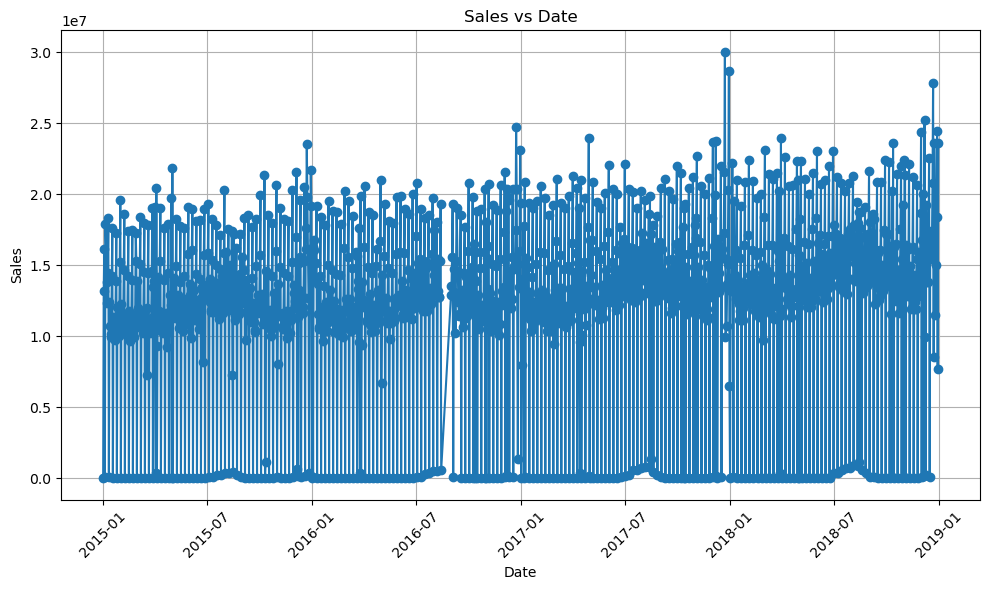

In [327]:
plt.figure(figsize=(10,6))
plt.plot(sales_train_formatted_df['DATE'], sales_train_formatted_df['SALES'], marker='o')
plt.title('Sales vs Date')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Task 3: Basic sales exploration
* Plot the sales over the year
* Bar graph with sales grouped by month
* Which day of the week (on average) does Mercadona have the best sales?

In [328]:
# Ploting the sales over the year for each year

def plot_sales_by_year_grid(df):
    years = sorted(df['DATE'].dt.year.unique())
    
    num_years = len(years)
    grid_size = 2
    num_rows = math.ceil(num_years / grid_size)  # Calculate the number of rows needed

    fig, axs = plt.subplots(num_rows, grid_size, figsize=(16, num_rows * 4))
    axs = axs.flatten()  

    for i, year in enumerate(years):
        sales_year_df = df.loc[df['DATE'].dt.year == year].copy() 
        
        sales_year_df['CUMULATIVE_SALES'] = sales_year_df['SALES'].cumsum()
        
        axs[i].plot(sales_year_df['DATE'], sales_year_df['CUMULATIVE_SALES'], color='blue')
        axs[i].set_title(f'Cumulative Sales in {year}', fontsize=10)
        axs[i].set_xlabel('Date', fontsize=8)
        axs[i].set_ylabel('Cumulative Sales', fontsize=8)
        axs[i].tick_params(axis='both', labelsize=8)
        axs[i].grid(True)
        axs[i].yaxis.set_major_locator(mticker.MaxNLocator(nbins=5, integer=True))  
    
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

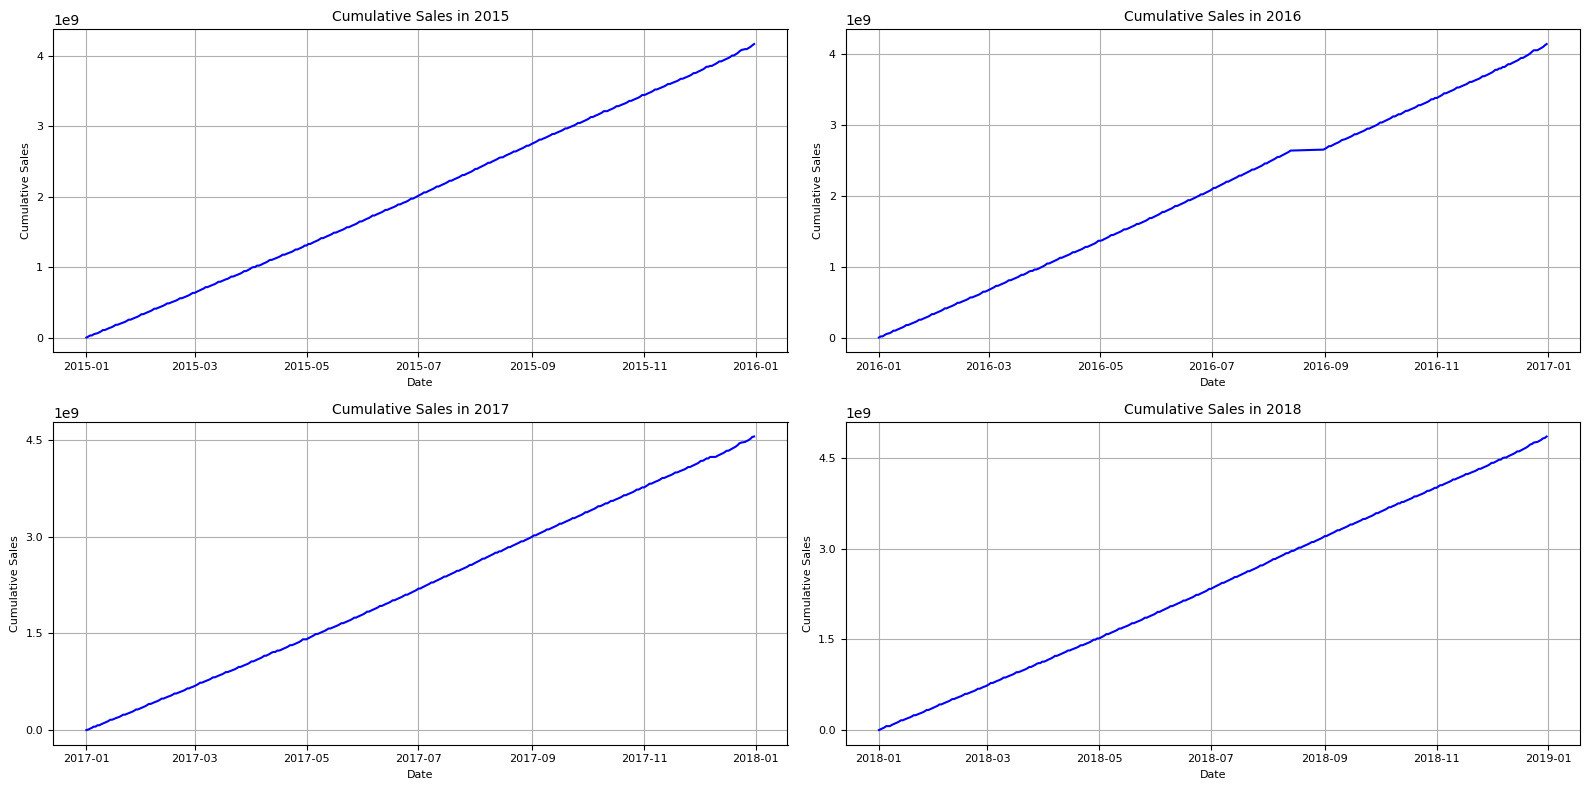

In [329]:
plot_sales_by_year_grid(sales_train_formatted_df)

In the 2016 plot there is a small horizontal section due to some missing data. This is later fixed with interpolation.

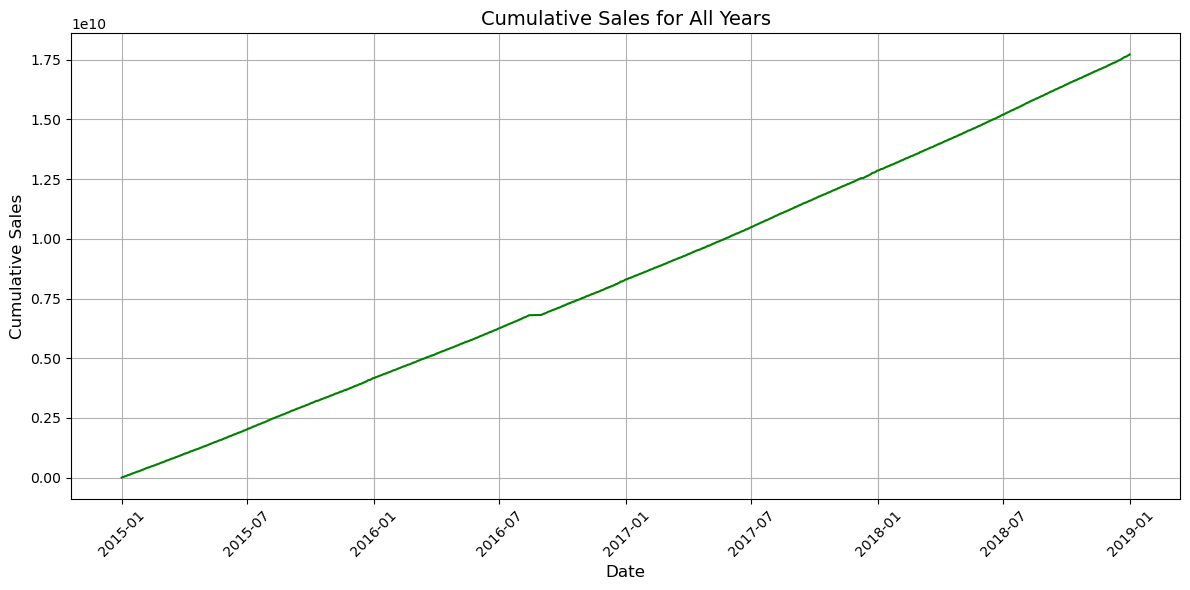

In [330]:
# Cumulative historical
def plot_total_cumulative_sales(df):
    df['CUMULATIVE_SALES_ALL'] = df['SALES'].cumsum()
    
    # Plot the cumulative sales for all years combined
    plt.figure(figsize=(12, 6))
    plt.plot(df['DATE'], df['CUMULATIVE_SALES_ALL'], color='green')
    plt.title('Cumulative Sales for All Years', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Sales', fontsize=12)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_total_cumulative_sales(sales_train_formatted_df)

In [331]:
def plot_grouped_sales_by_month_with_avg(df):
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    # Temporary columns
    df['Year'] = df['DATE'].dt.year
    df['Month'] = df['DATE'].dt.month
    
    monthly_sales = df.groupby(['Year', 'Month'])['SALES'].sum().unstack('Year')
    
    monthly_avg_sales = monthly_sales.mean(axis=1)

    ax = monthly_sales.plot(kind='bar', figsize=(12, 6), width=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    
    plt.plot(monthly_avg_sales.index - 1, monthly_avg_sales.values, linestyle='--', marker='o', color='black', label='Average')
    
    ax.set_xticklabels([calendar.month_name[i] for i in monthly_avg_sales.index], rotation=0)

    
    plt.title('Total Sales Grouped by Month for Each Year with Average', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Total Sales', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.legend(title='Year', loc='upper left')
    plt.show()
    
    df.drop(columns=['Year', 'Month'], inplace=True)

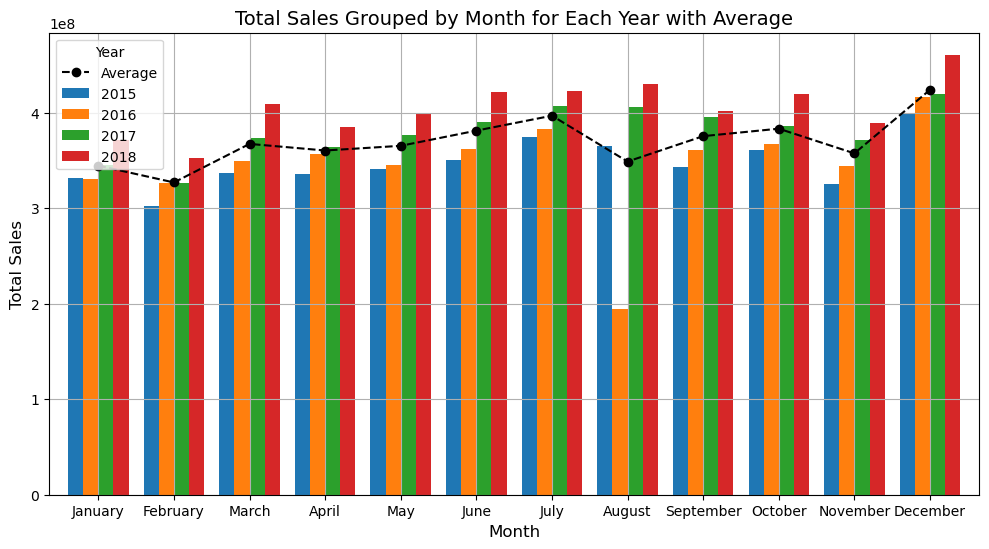

In [332]:
plot_grouped_sales_by_month_with_avg(sales_train_formatted_df)

The data for August 2016 contains several missing entries, resulting in a shortened bar. It is important to note that this specific bar does not accurately represent the true sales behavior for that period.

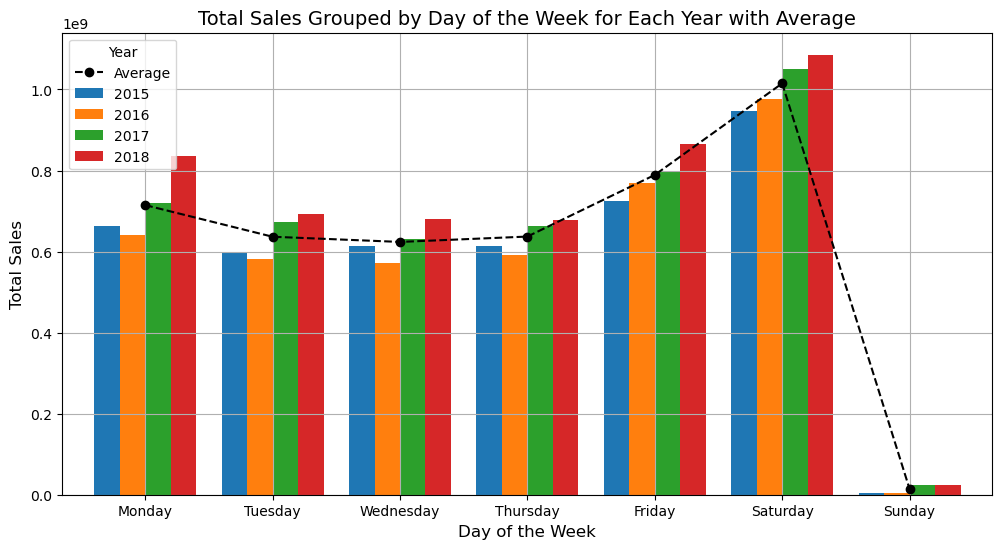

In [333]:
def plot_grouped_sales_by_day_of_week_with_avg(df):
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    # Temporary columns
    df['Year'] = df['DATE'].dt.year
    df['DayOfWeek'] = df['DATE'].dt.dayofweek  # 0 = Monday, 6 = Sunday
    
    weekly_sales = df.groupby(['Year', 'DayOfWeek'])['SALES'].sum().unstack('Year')
    
    weekly_avg_sales = weekly_sales.mean(axis=1)

    ax = weekly_sales.plot(kind='bar', figsize=(12, 6), width=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    
    plt.plot(weekly_avg_sales.index, weekly_avg_sales.values, linestyle='--', marker='o', color='black', label='Average')
    
    ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    
    plt.title('Total Sales Grouped by Day of the Week for Each Year with Average', fontsize=14)
    plt.xlabel('Day of the Week', fontsize=12)
    plt.ylabel('Total Sales', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.legend(title='Year', loc='upper left')
    plt.show()
    
    df.drop(columns=['Year', 'DayOfWeek'], inplace=True)

plot_grouped_sales_by_day_of_week_with_avg(sales_train_formatted_df)


By analyzing the total sales per day of the week, it is evident that Saturdays consistently register the highest sales, followed by Fridays. This pattern is consistent across all four years of available data.
The orange bars are affected by missing data byt this is fixed on the next task.

A plausible explanation for this trend is that many individuals have time off from work during the weekend, making Saturday the preferred day for completing weekly grocery shopping. Additionally, the fact that Mercadona remains closed on Sundays further reinforces the concentration of shopping activity on Saturdays.

##### Task 4: Outliers
* Identify possible outliers
* ¿Are there missing values?, ¿How would you deal with them?

**Identify Outliers**

Given the distinct behavior observed on Sundays compared to other days of the week, I opted to identify outliers in the sales dataset separately for Monday through Saturday and for Sunday. This ensures that the differing sales patterns are appropriately accounted for when detecting anomalies.

We use the Z-score method for outiler (any data points more than 3 standard deviations from the mean) detection  separately for the `sales_no_sundays_df` and `sales_sundays_df datasets`.

In [334]:
sales_no_sundays_df = sales_train_formatted_df[sales_train_formatted_df['DATE'].dt.weekday != 6]
sales_sundays_df = sales_train_formatted_df[sales_train_formatted_df['DATE'].dt.weekday == 6]


Outliers for sales_no_sundays_df: 31

           DATE         SALES  CUMULATIVE_SALES_ALL
0    2015-01-01  1.103868e+03          1.103868e+03
91   2015-04-03  3.865408e+05          1.000223e+09
119  2015-05-01  1.938186e+04          1.306021e+09
283  2015-10-12  1.133322e+06          3.213207e+09
340  2015-12-08  1.852770e+05          3.855026e+09
363  2016-01-01  2.870806e+03          4.165661e+09
446  2016-03-25  3.768360e+05          5.104072e+09
630  2016-10-12  2.570143e+04          7.310746e+09
650  2016-11-01  5.025015e+04          7.540399e+09
685  2016-12-06  1.654610e+05          7.956130e+09
687  2016-12-08  1.714684e+05          7.976693e+09
704  2016-12-26  1.350963e+06          8.213389e+09
715  2017-01-06  7.559334e+03          8.353598e+09
813  2017-04-14  3.906486e+05          9.513527e+09
830  2017-05-01  4.411206e+03          9.709612e+09
936  2017-08-15  1.398575e+06          1.107691e+10
994  2017-10-12  5.573682e+04          1.182125e+10
1014 2017-11-01  7.636938

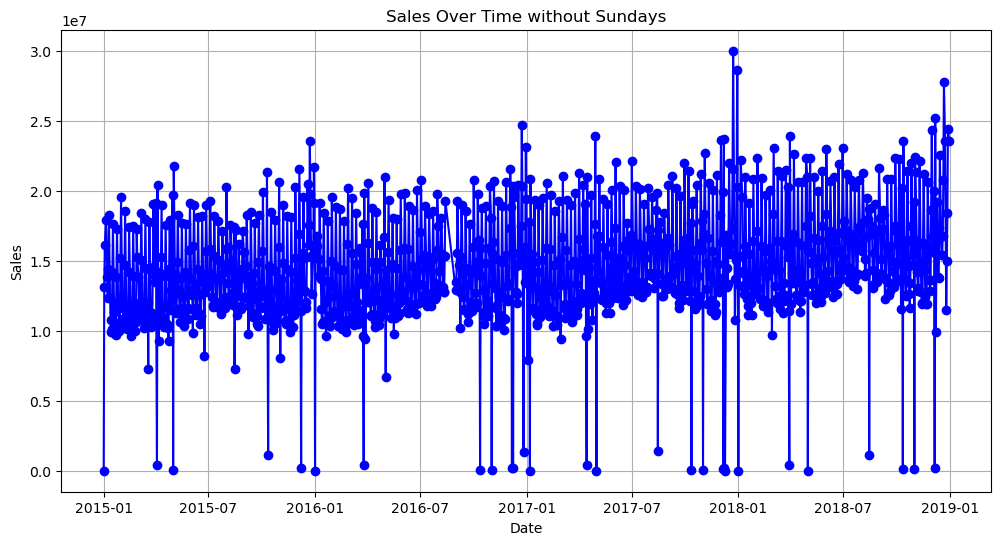

In [335]:
# Z-Score method for detecting outliers

def detect_outliers_zscore(df):
    z_scores = stats.zscore(df['SALES'])
    outliers = df[abs(z_scores) > 3]
    return outliers

outliers_no_sundays = detect_outliers_zscore(sales_no_sundays_df)
outliers_sundays = detect_outliers_zscore(sales_sundays_df)

print(f"\nOutliers for sales_no_sundays_df: {len(outliers_no_sundays)}\n")
print(outliers_no_sundays)

plt.figure(figsize=(12, 6))
plt.plot(sales_no_sundays_df['DATE'], sales_no_sundays_df['SALES'], marker='o', linestyle='-', color='blue')
plt.title('Sales Over Time without Sundays')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

Several of these dates correspond to public holidays in Spain, such as New Year's Day (January 1), Epiphany (January 6), and December 22 and 23 (which are close to Christmas Eve). Consumer activity in preparation for these holidays could account for deviations for typical behaviour. To account for this effect, a "holiday" feature could be introduced into the model to capture the impact of these events on sales patterns.

The outlayer on the `2017-12-09` corresponds to a problem in the dataset. Since it was a saturday, we can sustitue that entry by the average of the satrudays on that year:

In [336]:
sales_2017_saturdays = sales_train_formatted_df[(sales_train_formatted_df['DATE'].dt.year == 2017) & 
                                                (sales_train_formatted_df['DATE'].dt.weekday == 5)]

average_saturday_2017_sales = sales_2017_saturdays['SALES'].mean()
sales_train_formatted_df.loc[sales_train_formatted_df['DATE'] == '2017-12-09', 'SALES'] = average_saturday_2017_sales

sales_train_formatted_df[sales_train_formatted_df['DATE'] == '2017-12-09']

,DATE,SALES,CUMULATIVE_SALES_ALL
1052,2017-12-09,2.021574e+07,1.254215e+10



Outliers for sales_sundays_df:4

           DATE        SALES  CUMULATIVE_SALES_ALL
1067 2017-12-24  9948042.868          1.276449e+10
1073 2017-12-31  6532775.450          1.285949e+10
1429 2018-12-23  8534993.248          1.759621e+10
1435 2018-12-30  7664277.158          1.769684e+10


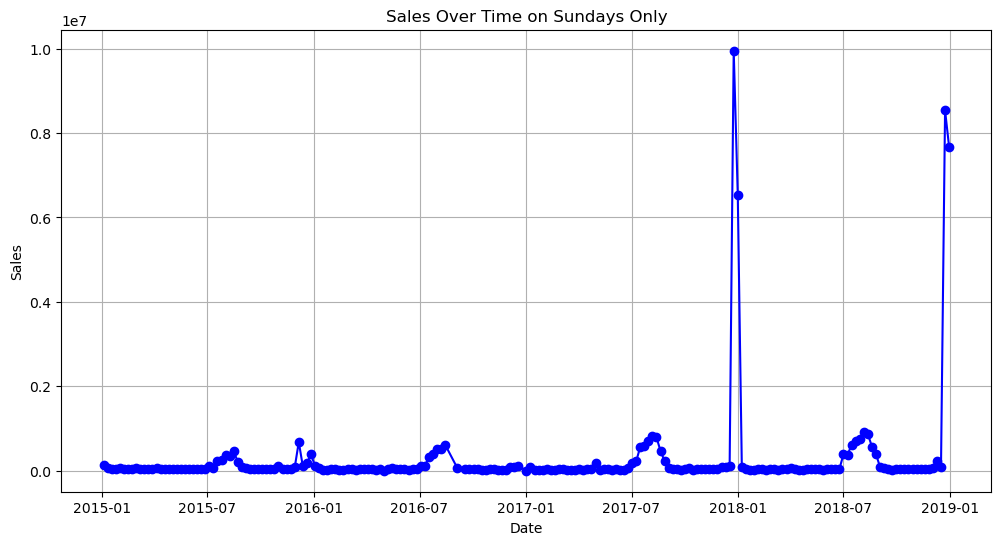

In [337]:
print(f"\nOutliers for sales_sundays_df:{len(outliers_sundays)}\n")
print(outliers_sundays)

# Plot the data for Sundays only
plt.figure(figsize=(12, 6))
plt.plot(sales_sundays_df['DATE'], sales_sundays_df['SALES'], marker='o', linestyle='-', color='blue')
plt.title('Sales Over Time on Sundays Only')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

The outliers identified using the Z-score method for Sundays are clearly visible in the plots and correspond to heightened shopping activity in preparation for New Year's Eve and Christmas Eve. These anomalies reflect the expected surge in consumer demand during the holiday season.

These spikes should not be removed, as they provide valuable information about seasonal or event-based trends.

**Missing values**

As mentioned during *Task 2* there are several missing dates in sales_train_dataset, some of which are explained by hollidays or festivities. 

Missing dates in `sales_train_dataset.csv`

| **2015**      | **2016**          | **2017**      | **2018**      |
|---------------|-------------------|---------------|---------------|
| 2015-01-06    | 2016-01-06        | 2017-12-25    | 2018-01-06    |
| 2015-12-25    | 2016-08-15        |               | 2018-12-25    |
|               | 2016-08-16        |               |               |
|               | 2016-08-17        |               |               |
|               | 2016-08-18        |               |               |
|               | 2016-08-19        |               |               |
|               | 2016-08-20        |               |               |
|               | 2016-08-21        |               |               |
|               | 2016-08-22        |               |               |
|               | 2016-08-23        |               |               |
|               | 2016-08-24        |               |               |
|               | 2016-08-25        |               |               |
|               | 2016-08-26        |               |               |
|               | 2016-08-27        |               |               |
|               | 2016-08-28        |               |               |
|               | 2016-08-29        |               |               |
|               | 2016-08-30        |               |               |
|               | 2016-09-11        |               |               |
|               | 2016-12-25        |               |               |


Both on Christmas and Epiphany, Mercadona remains closed, which explains the absence of data for these dates. An exception to this is January 6, 2017 (Epiphany), where a sales value of 7559.33 is recorded. This entry is significantly lower than typical sales and can be considered an outlier.

To handle missing data due to store closures, a common approach would be to impute the missing sales with zero and possibly introduce a `HOLIDAY` flag to mark these dates.

In contrast, there is missing data from August 15 to August 30, 2016, which does not appear to be related to store closures, as Mercadona was reportedly open during that period (this can be checked in `calendar.csv`). Therefore, this represents a true gap in the dataset. One potential solution is to interpolate the missing sales values. A straightforward approach could involve using corresponding days from August 2017 (aligning the weekdays) and copying the sales values into the missing dates. These values could then be rescaled by a factor that accounts for the lower sales in 2016 compared to 2017.

In [338]:
# Missing values in the dataset
missing_values = sales_train_formatted_df.isnull().sum()
print("Date entries with missing sales inforamtion:")
print(missing_values[missing_values > 0])


# Missing dates in the dataset
if not missing_dates.empty:
    print(f"Missing dates found: {len(missing_dates)}")
    #print(missing_dates)
else:
    print("No missing dates in the dataset.")

Date entries with missing sales inforamtion:
Series([], dtype: int64)
Missing dates found: 24


In [339]:
sales_train_formatted_df[sales_train_formatted_df['DATE'] == '2017-01-06']

,DATE,SALES,CUMULATIVE_SALES_ALL
715,2017-01-06,7559.334,8.353598e+09


Interpolating data in order to fill the missing values in August 2016.

The scale factor to adjust the artificially created 2016 data is done by comparing the average of July-September of 2016 to that of 2017. The correscted dataset is stored in `sales_train_filled_df`.

In [340]:
# Calculate scale factor to adjust the 2016 values
sales_july_sep_2016 = sales_train_formatted_df[(sales_train_formatted_df['DATE'].dt.year == 2016) & 
                                               (sales_train_formatted_df['DATE'].dt.month.isin([7, 9]))]

sales_july_sep_2017 = sales_train_formatted_df[(sales_train_formatted_df['DATE'].dt.year == 2017) & 
                                               (sales_train_formatted_df['DATE'].dt.month.isin([7, 9]))]

avg_sales_july_sep_2016 = sales_july_sep_2016['SALES'].mean()
avg_sales_july_sep_2017 = sales_july_sep_2017['SALES'].mean()

yrScaler = avg_sales_july_sep_2016 / avg_sales_july_sep_2017
yrScaler = round(yrScaler, 4)

#print(f"Average sales in July and September 2016: {avg_sales_july_sep_2016}")
#print(f"Average sales in July and September 2017: {avg_sales_july_sep_2017}")
print(f"Scale factor to correct the data from 2017 to 2016: {yrScaler}")

Scale factor to correct the data from 2017 to 2016: 0.9429


In [341]:
# Date ranges
missing_dates = pd.date_range(start='2016-08-15', end='2016-08-30', freq='D')
reference_dates_2017 = pd.date_range(start='2017-08-14', end='2017-08-29', freq='D')

# Corresponding 2017 sales + scaling (using .loc to avoid the SettingWithCopyWarning)
reference_sales_2017 = sales_train_formatted_df[sales_train_formatted_df['DATE'].isin(reference_dates_2017)].copy()
reference_sales_2017.loc[:, 'SALES'] = reference_sales_2017['SALES'] * yrScaler

# Create missing entries for 2016 using the scaled sales from 2017
missing_entries = reference_sales_2017.copy()
missing_entries['DATE'] = missing_dates.values

# Concatenate the missing entries with the original dataframe
sales_train_filled_df = pd.concat([sales_train_formatted_df, missing_entries]).sort_values(by='DATE').reset_index(drop=True)

# Check the filled data for the date range
sales_train_filled_df[sales_train_filled_df['DATE'].between('2016-08-15', '2016-08-30')]


,DATE,SALES,CUMULATIVE_SALES_ALL
589,2016-08-15,1.870917e+07,1.107552e+10
590,2016-08-16,1.318716e+06,1.107691e+10
591,2016-08-17,1.620700e+07,1.109410e+10
592,2016-08-18,1.323791e+07,1.110814e+10
593,2016-08-19,1.467058e+07,1.112370e+10
594,2016-08-20,1.679949e+07,1.114152e+10
595,2016-08-21,4.414544e+05,1.114199e+10
596,2016-08-22,1.535251e+07,1.115827e+10
597,2016-08-23,1.261929e+07,1.117165e+10
598,2016-08-24,1.177877e+07,1.118414e+10


We add the entries for December 25th and January 6th across multiple years to the `sales_train_filled_df` dataset. These specific dates are marked with a holidays flag set to True. For all other entries in the dataset, the holidays flag is set to False, ensuring proper identification of holidays within the data.

Since for `2017-01-06` we already had data, this is kept.

In [342]:
# Define the specific holiday dates
holiday_dates = pd.to_datetime(['2015-01-06', 
                                '2015-12-25',
                                '2016-01-06',
                                '2016-12-25',
                                '2017-01-06',
                                '2017-12-25', 
                                '2018-01-06', 
                                '2018-12-25'
                                ])

# create and set 'holidays' flag to False
sales_train_filled_df['HOLIDAY'] = False


# Since there is data for holidays day (2017-01-06), we loop through each holiday date
for date in holiday_dates:
    if date in sales_train_filled_df['DATE'].values:
        #holidays = True
        print(f"Data existing for holiday in {date.date()}")
        sales_train_filled_df.loc[sales_train_filled_df['DATE'] == date, 'HOLIDAY'] = True
    else:
        # SALES = 0 and holidays = True
        missing_entry = pd.DataFrame({'DATE': [date], 'SALES': [0], 'HOLIDAY': [True]})
        sales_train_filled_df = pd.concat([sales_train_filled_df, missing_entry], ignore_index=True)


sales_train_filled_df = sales_train_filled_df.sort_values(by='DATE').reset_index(drop=True)

# Recalculate cumulative sales 
sales_train_filled_df['CUMULATIVE_SALES_ALL'] = sales_train_filled_df['SALES'].cumsum()



sales_train_filled_df[sales_train_filled_df['DATE'].isin(holiday_dates)]


Data existing for holiday in 2017-01-06


,DATE,SALES,CUMULATIVE_SALES_ALL,HOLIDAY
5,2015-01-06,0.000,4.738010e+07,True
358,2015-12-25,0.000,4.080177e+09,True
370,2016-01-06,0.000,4.214887e+09,True
723,2016-12-25,0.000,8.405466e+09,True
735,2017-01-06,7559.334,8.547026e+09,True
1088,2017-12-25,0.000,1.297814e+10,True
1100,2018-01-06,0.000,1.313803e+10,True
1453,2018-12-25,0.000,1.783343e+10,True


To handle the missing data for 2016-09-11, we perform interpolation by calculating the average sales between the same weekday from the previous and subsequent weeks. We will implement this logic in a function that identifies the missing date, computes the average sales from the surrounding days, and updates the dataset accordingly.

In [343]:
import pandas as pd

# Modify the function to calculate sales on missing_date based on the sales from missing_date+7 and missing_date-7
def interpolate_missing_entry(df, missing_date, holiday=False):
    missing_date = pd.to_datetime(missing_date)
    
    sales_before = df.loc[df['DATE'] == missing_date - pd.Timedelta(days=7), 'SALES']
    sales_after = df.loc[df['DATE'] == missing_date + pd.Timedelta(days=7), 'SALES']
    
    if not sales_before.empty and not sales_after.empty:
        average_sales = (sales_before.values[0] + sales_after.values[0]) / 2
    else:
        print("Warning, missing data")
        average_sales = None
    
    # New entry
    new_entry = pd.DataFrame({
        'DATE': [missing_date],
        'SALES': [average_sales],
        'HOLIDAY': [holiday]  # Set the holiday flag based on the input argument
    })

    # Append the new entry to the dataframe
    df_updated = pd.concat([df, new_entry]).sort_values(by='DATE').reset_index(drop=True)

    # Recalculate the CUMULATIVE_SALES_ALL as the cumulative sum of SALES
    df_updated['CUMULATIVE_SALES_ALL'] = df_updated['SALES'].cumsum()

    return df_updated

sales_train_filled_df = interpolate_missing_entry(sales_train_filled_df, '2016-09-11')

sales_train_filled_df[sales_train_filled_df['DATE'] == '2016-09-11']


,DATE,SALES,CUMULATIVE_SALES_ALL,HOLIDAY
619,2016-09-11,47644.48,7.140040e+09,False


In [344]:
missing_dates_new = find_missing_dates(sales_train_filled_df)


No missing dates in the dataset.


Now that all missing values have been addressed, we can regenerate the plots from the previous analyses, observing improved behavior in the data representation. This is particularly evident in the plot titled 'Total Sales Grouped by Month for Each Year with Average', where the previous anomaly in the orange bar for August has been corrected, resulting in a more accurate depiction of the sales trend.

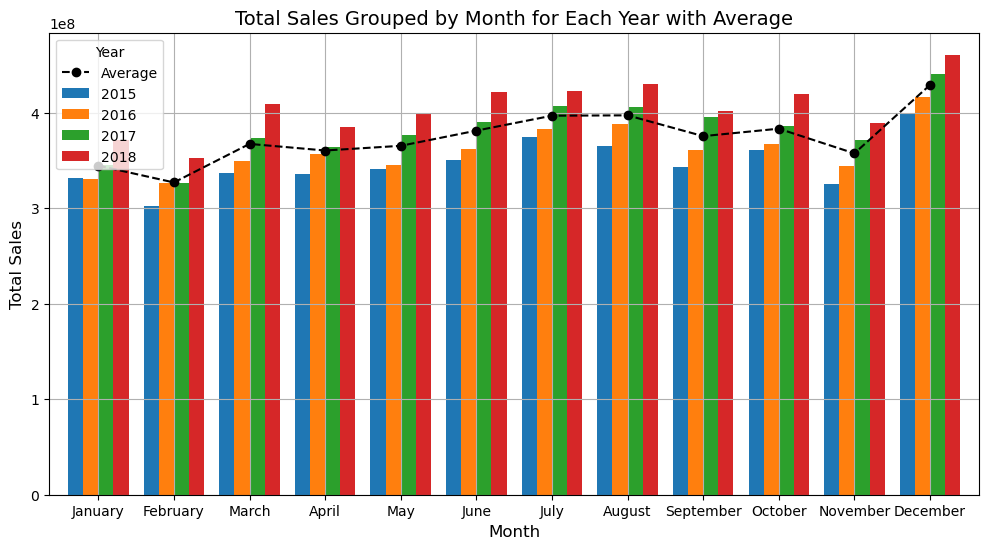

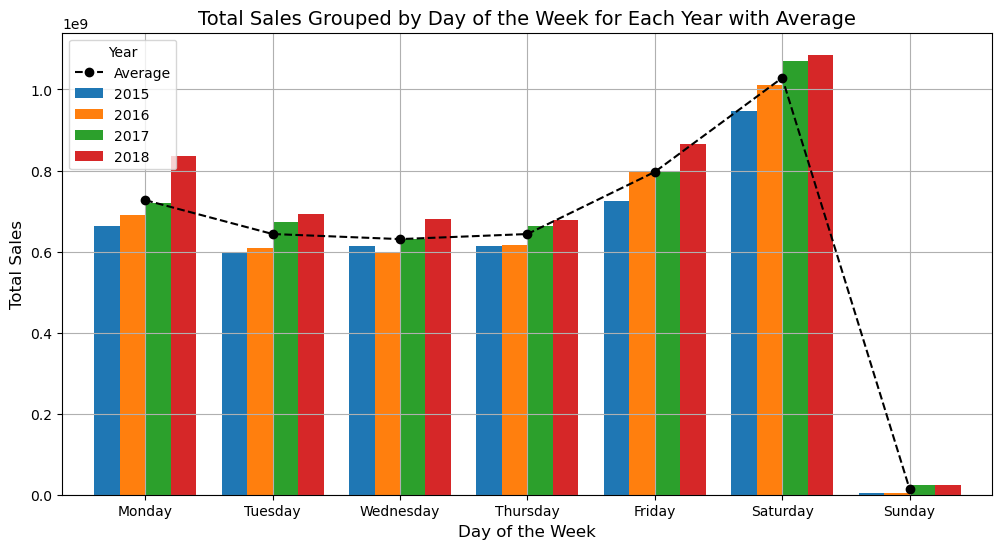

In [345]:
plot_grouped_sales_by_month_with_avg(sales_train_filled_df)
plot_grouped_sales_by_day_of_week_with_avg(sales_train_filled_df)


The data has now been corrected, leading to a more accurate representation. Notably, for each month or weekday, the sales figures show a consistent improvement across the years, reflecting a clearer year-over-year growth trend.

Additionally, when plotting cumulative sales, we no longer observe the horizontal plateau caused by the missing data. Instead, we see a smoother and continuous cumulative distribution, reflecting a more realistic sales trend over time. This correction enhances the overall accuracy of the data analysis and provides a clearer picture of sales performance.

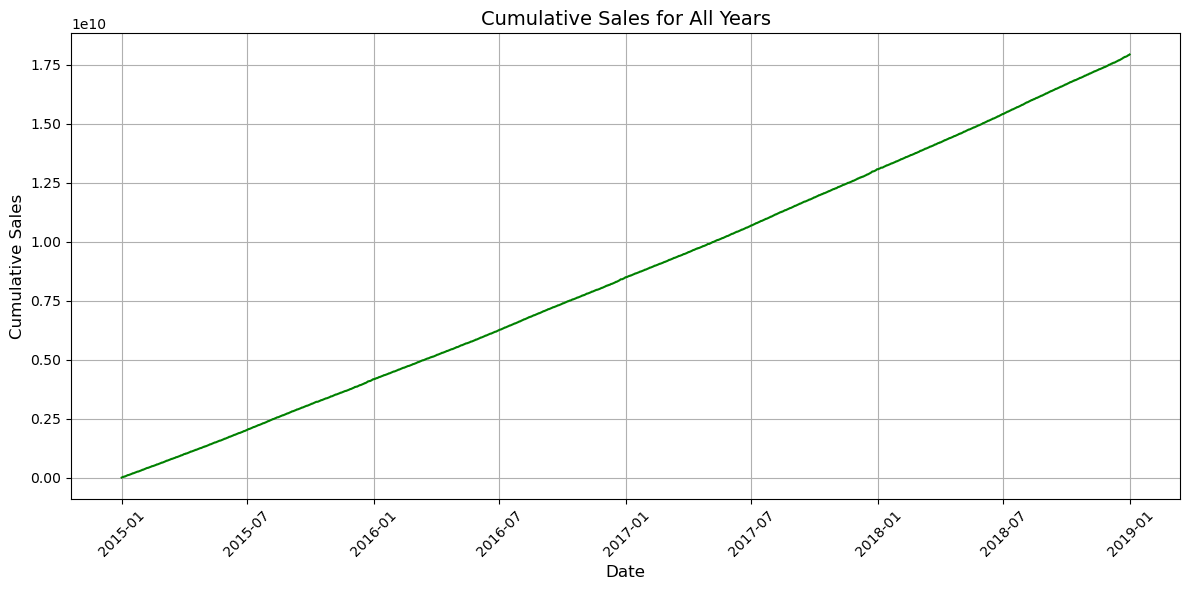

In [346]:
plot_total_cumulative_sales(sales_train_filled_df)

##### Taskk 5: Open/Close datase
* Plot a two-line graph. Each line should represent the amount of stores open/close at each day

 **Checking Data in Calendar.csv**

To ensure data quality in the `Calendar.csv` file, we begin by identifying missing dates using the previously defined `find_missing_dates` function. Next, we perform a thorough exploration for inconsistencies by verifying the validity of entries in the categorical columns. This includes checking for any invalid or unexpected values. Additionally, we assess potential outliers in the `OPENING_TIME` and `CLOSING_TIME` columns and examine the dataset for duplicate records, specifically focusing on combinations of `DATE` and `STORE_ID`.

In [347]:
find_missing_dates(calendar_df)

No missing dates in the dataset.


DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [348]:
# Check unique values in categorical columns
print("Unique values in 'STATE':", calendar_df['STATE'].unique())
print("Unique values in 'HOLIDAY_AND_CLOSED':", calendar_df['HOLIDAY_AND_CLOSED'].unique())
print("Unique values in 'UNDER_REFORM':", calendar_df['UNDER_REFORM'].unique())

Unique values in 'STATE': ['C' 'A' 'FA' 'FM' 'CR']
Unique values in 'HOLIDAY_AND_CLOSED': [1 0]
Unique values in 'UNDER_REFORM': [0 1]


count      2395831
unique           9
top       09:00:00
freq       2154874
Name: OPENING_TIME, dtype: object


count      2395831
unique          15
top       21:30:00
freq       1873854
Name: CLOSING_TIME, dtype: object


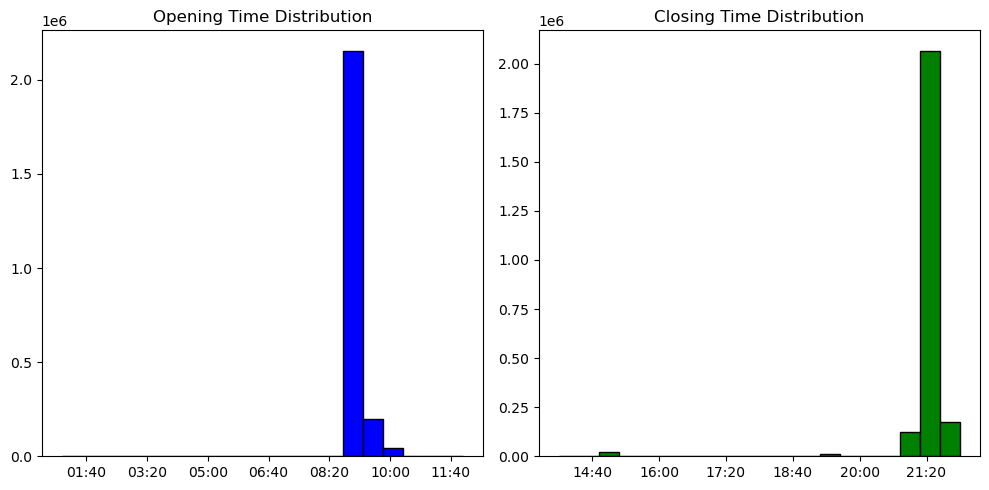

In [349]:
# Outliers

def time_to_minutes(time_obj):
    if isinstance(time_obj, pd._libs.tslibs.nattype.NaTType) or pd.isna(time_obj):
        return np.nan
    return time_obj.hour * 60 + time_obj.minute

def minutes_to_time(minutes):
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    return f'{hours:02}:{mins:02}'
    
calendar_df['OPENING_TIME_MINUTES'] = calendar_df['OPENING_TIME'].apply(time_to_minutes)
calendar_df['CLOSING_TIME_MINUTES'] = calendar_df['CLOSING_TIME'].apply(time_to_minutes)

print(calendar_df['OPENING_TIME'].describe())
print("\n")
print(calendar_df['CLOSING_TIME'].describe())

# Plot distributions
plt.figure(figsize=(10, 5))

# Opening time 
plt.subplot(1, 2, 1)
plt.hist(calendar_df['OPENING_TIME_MINUTES'].dropna(), bins=20, color='blue', edgecolor='black')
plt.title('Opening Time Distribution')

ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=8))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: minutes_to_time(x)))

# Closing time 
plt.subplot(1, 2, 2)
plt.hist(calendar_df['CLOSING_TIME_MINUTES'].dropna(), bins=20, color='green', edgecolor='black')
plt.title('Closing Time Distribution')

ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=8))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: minutes_to_time(x)))


plt.tight_layout()
plt.show()


# drop columns after plotting
calendar_df.drop(columns=['CLOSING_TIME_MINUTES', 'OPENING_TIME_MINUTES'], inplace=True)


In [350]:
duplicates = calendar_df.duplicated(subset=['DATE', 'STORE_ID'])
print(f"Number of duplicates: {duplicates.sum()}")

#calendar_df[calendar_df.duplicated(subset=['DATE', 'STORE_ID'], keep=False)]
print("Droping duplicates")
calendar_df.drop_duplicates(subset=['DATE', 'STORE_ID'], inplace=True)

duplicates = calendar_df.duplicated(subset=['DATE', 'STORE_ID'])
print(f"New number of duplicates: {duplicates.sum()}")

Number of duplicates: 2
Droping duplicates
New number of duplicates: 0


In [351]:
#calendar_df.head(2000)

Now that the `Calendar.csv` dataset has been thoroughly explored and cleaned, we can proceed to visualize the data by plotting a two-line graph representing the number of stores open and closed on each day. This will help us analyze trends in store operations, such as seasonal patterns or periods of closure, based on the prepared data.

In [352]:
calendar_df_tmp = pd.DataFrame(calendar_df['DATE'].unique(), columns=['DATE'])

# Initialize 'open' and 'close' columns with zeros
calendar_df_tmp['open'] = 0
calendar_df_tmp['close'] = 0

# Calculate the number of open stores (STATE == 'A') and closed stores (STATE == 'C') for each date
#open_stores_count = calendar_df[calendar_df['STATE'] == 'A'].groupby('DATE').size()
#closed_stores_count = calendar_df[calendar_df['STATE'] == 'C'].groupby('DATE').size()

open_stores_count = calendar_df[calendar_df['STATE'].isin(['A', 'FA', 'FM'])].groupby('DATE').size()
closed_stores_count = calendar_df[calendar_df['STATE'].isin(['C', 'CR'])].groupby('DATE').size()


calendar_df_tmp.set_index('DATE', inplace=True)  # Set index to 'DATE' to align with the grouping result
calendar_df_tmp['open'] = open_stores_count
calendar_df_tmp['close'] = closed_stores_count

calendar_df_tmp.reset_index(inplace=True)

calendar_df_tmp['open'].fillna(0, inplace=True)
calendar_df_tmp['close'].fillna(0, inplace=True)

calendar_df_tmp['total'] = calendar_df_tmp['open'] + calendar_df_tmp['close']

calendar_df_tmp['open'] = calendar_df_tmp['open'].astype(int)
calendar_df_tmp['close'] = calendar_df_tmp['close'].astype(int)
calendar_df_tmp['total'] = calendar_df_tmp['total'].astype(int)

calendar_df_tmp.head(5)

,DATE,open,close,total
0,2015-01-01,0,1521,1521
1,2015-01-02,1508,13,1521
2,2015-01-03,1521,0,1521
3,2015-01-04,10,1511,1521
4,2015-01-05,1520,1,1521


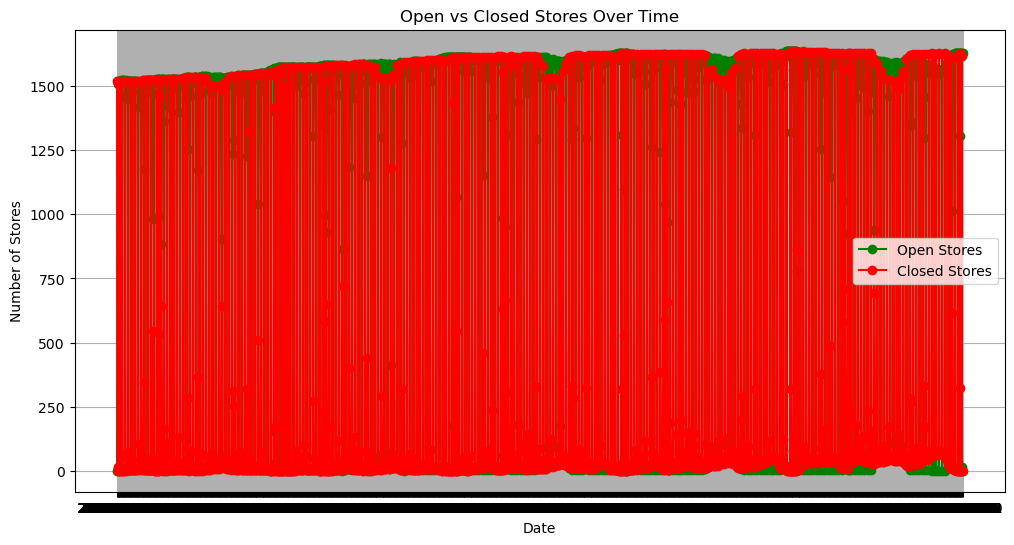

In [353]:
plt.figure(figsize=(12, 6))

plt.plot(calendar_df_tmp['DATE'], calendar_df_tmp['open'], label='Open Stores', color='green', linestyle='-', marker='o')

plt.plot(calendar_df_tmp['DATE'], calendar_df_tmp['close'], label='Closed Stores', color='red', linestyle='-', marker='o')
# Add titles and labels
plt.title('Open vs Closed Stores Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Stores')
plt.legend()

# Display the grid and plot
plt.grid(True)
plt.show()

Since this plot is is so densely packed with data that individual changes cannot be distinguished. This is knwon as oversaturatation. Let's split the data between sundays and the rest of the days to solve this issue.

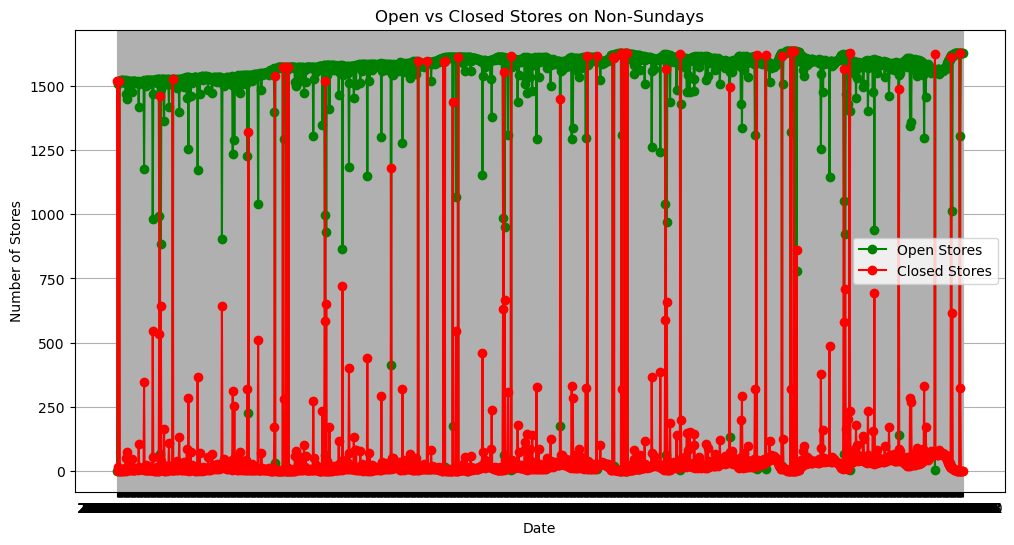

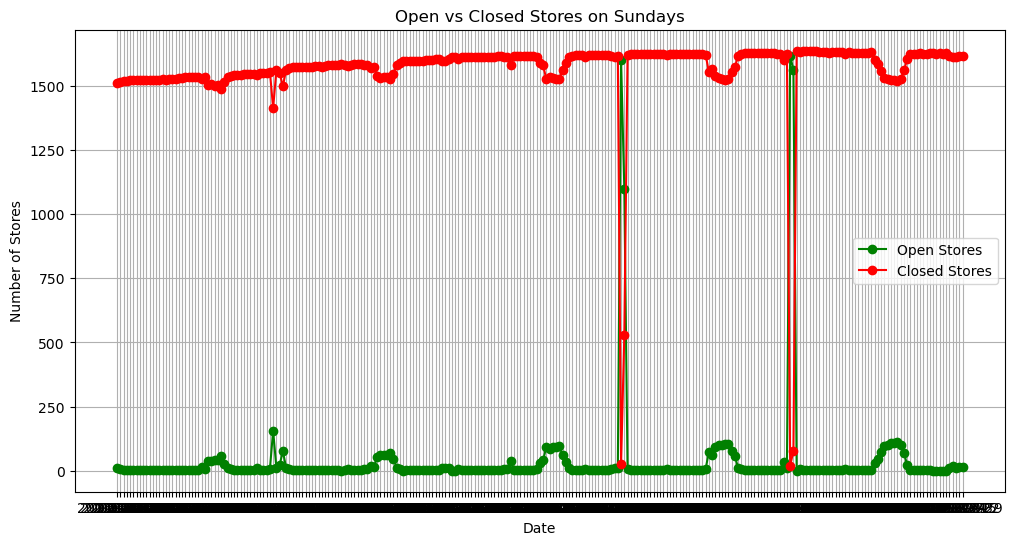

In [354]:
calendar_df_tmp['day_of_week'] = pd.to_datetime(calendar_df_tmp['DATE']).dt.dayofweek
sundays_df = calendar_df_tmp[calendar_df_tmp['day_of_week'] == 6]
rest_of_days_df = calendar_df_tmp[calendar_df_tmp['day_of_week'] != 6]

# Plot for the rest of the days
plt.figure(figsize=(12, 6))
plt.plot(rest_of_days_df['DATE'], rest_of_days_df['open'], label='Open Stores', color='green', linestyle='-', marker='o')
plt.plot(rest_of_days_df['DATE'], rest_of_days_df['close'], label='Closed Stores', color='red', linestyle='-', marker='o')
plt.title('Open vs Closed Stores on Non-Sundays')
plt.xlabel('Date')
plt.ylabel('Number of Stores')
plt.legend()
plt.grid(True)
plt.show()


# Plot for Sundays
plt.figure(figsize=(12, 6))
plt.plot(sundays_df['DATE'], sundays_df['open'], label='Open Stores', color='green', linestyle='-', marker='o')
plt.plot(sundays_df['DATE'], sundays_df['close'], label='Closed Stores', color='red', linestyle='-', marker='o')
plt.title('Open vs Closed Stores on Sundays')
plt.xlabel('Date')
plt.ylabel('Number of Stores')
plt.legend()
plt.grid(True)
plt.show()



##### Task 6: Seasonality
* ¿Does sales follow a trend?
* ¿Can you identify a pattern on sales?
* ¿Are sales regular over all the year?

The analysis reveals several patterns and trends that are evident from the various plots produced:

1. **Yearly Sales Improvement**:
    - Sales show a clear upward trend each year. This is particularly noticeable in the plots for total sales grouped by month or day for each year. Using 2018 as the reference, the second-best year, 2017, recorded less than 94% of 2018's sales. Refer to the table below for more details. 
    
    - Nevertheless, part of this improvement can be explained by the **IPC**. Since the IPC value is positve for all months, the prices increase year after year and, hece, the sales. 
    

2. **Monthly Sales Distribution**:
    - **2.1 December Peak**: The month with the highest sales is December, driven by holiday shopping for Christmas and New Year's preparations. Consumers tend to stock up on food and gifts, which explains the significant sales spike during this period, a common trend for most retailers.
    
    - **2.2 Summer Sales**: Sales remain strong during the summer months (June, July, and August), which are popular vacation periods in Spain. Many people travel to coastal regions, where Mercadona operates, resulting in increased consumption. Sales during these months reach approximately 93% of December's levels.
    
    - **2.3 Baseline Consumer Behavior**: The remaining months of the year reflect more typical or baseline consumer behavior, with balanced sales figures.
    
    - **2.4 September/October Boost**: September and October also exhibit relatively strong sales, potentially linked to back-to-school shopping. Families purchase supplies, snacks, and groceries in preparation for the school year after the summer break.
    
    - **2.5 Post-Holiday Dip**: January and February, particularly January, have the lowest sales. This can be attributed to reduced consumption after the financial efforts of December’s holiday shopping.
    

3. **Day of the Week Patterns**:
    - **Saturday Dominance**: Saturdays have the highest sales volume by a significant margin. If Saturday's sales are considered 100%, the second-best day, Friday, reaches only 77.8%, and Monday follows at 71.0%. See the table below for more details.

4. **Pre-Holiday Sales Spikes**:
    - Another noticeable trend is the occurrence of sales spikes just before major holidays, as consumers prepare for celebrations by purchasing larger quantities of goods.


In [355]:
sales_train_filled_df['Year'] = sales_train_filled_df['DATE'].dt.year
average_sales_per_year = sales_train_filled_df.groupby('Year')['SALES'].mean()
average_sales_2018 = average_sales_per_year[2018]
relative_fractions = 100* average_sales_per_year / average_sales_2018
#print(relative_fractions)

| Year | Sales (as % of 2018) |
|------|----------------------|
| 2018 | 100    %             |
| 2017 | 93.79  %             |
| 2016 | 88.56  %             |
| 2015 | 85.70  %             |


In [356]:
sales_train_filled_df['Month'] = sales_train_filled_df['DATE'].dt.month

average_sales_per_month = sales_train_filled_df.groupby('Month')['SALES'].mean()
average_sales_december = average_sales_per_month[12]
relative_sales_per_month = (average_sales_per_month / average_sales_december) * 100
#print(relative_sales_per_month)

| Month      | Sales (as % of December) |
|------------|--------------------------|
| January    | 81.27  %                  |
| February   | 84.62  %                  |
| March      | 86.64  %                  |
| April      | 87.84  %                  |
| May        | 86.17  %                  |
| June       | 92.91  %                  |
| July       | 93.60  %                  |
| August     | 93.69  %                  |
| September  | 90.75  %                  |
| October    | 90.40  %                  |
| November   | 87.11  %                  |
| December   | 100 %                  |


In [357]:
sales_train_filled_df['DayOfWeek'] = sales_train_filled_df['DATE'].dt.dayofweek

average_sales_per_day = sales_train_filled_df.groupby('DayOfWeek')['SALES'].mean()
average_sales_saturday = average_sales_per_day[5]
relative_sales_per_day = (average_sales_per_day / average_sales_saturday) * 100
#print(relative_sales_per_day)

| Day of the Week | Sales (as % of Saturday) |
|-----------------|--------------------------|
| Monday          | 71.01 %                     |
| Tuesday         | 63.15 %                    |
| Wednesday       | 61.92 %                    |
| Thursday        | 62.85 %                    |
| Friday          | 77.82 %                    |
| Saturday        | 100   %                    |
| Sunday          | 1.38  %                    |


##### Task 7: Optionaly
* If consider there are any kind of analysis that still can be done and would be useful for a forecasting task, that's the place to do it

Further studies:

1. **Explore IPC**

Let's explore the `ipc_history_df`. 
Standing for Índice de Precios al Consumidor, the IPC is an economic indicator that measures the average change over time in the prices paid by consumers for goods and services. These compare the prices of a month with that of the previous month.

<!--
A positive value means that prices for goods and services increased compared to the same period in the previous year. For example, in June 2015 (IPC = 1.8), prices were 1.8% higher than in June 2014.

Negative IPC Value: A negative value means that prices have decreased compared to the same period in the previous year. For example, in January 2015 (IPC = -0.4), prices were 0.4% lower than in January 2014.
-->

In [359]:
# First let's look for missing values
print(ipc_history_df.isnull().sum())

FEC_VENTA    0
IPC_VALUE    0
dtype: int64


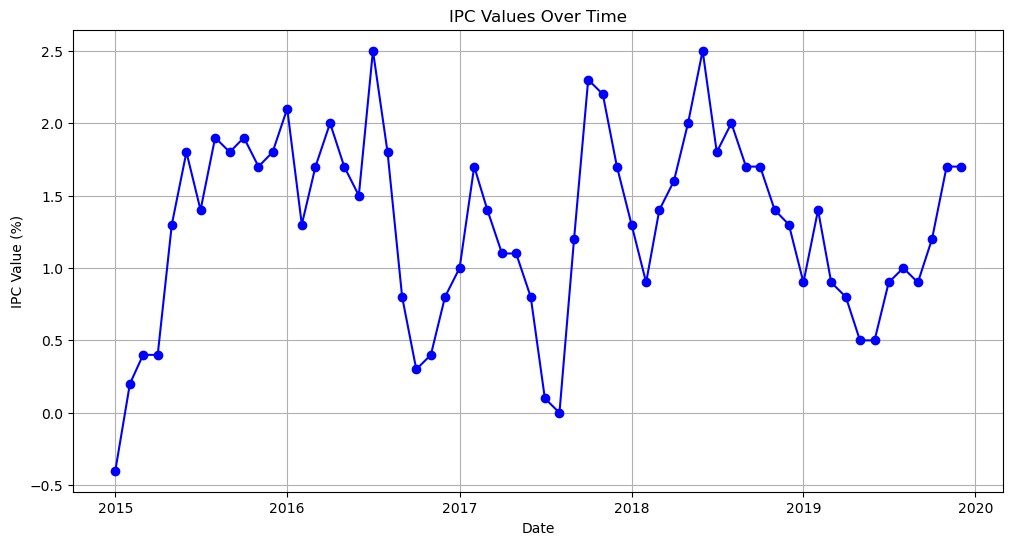

In [360]:
ipc_history_df['FEC_VENTA'] = pd.to_datetime(ipc_history_df['FEC_VENTA'])

# Plot the IPC values over time
plt.figure(figsize=(12, 6))
plt.plot(ipc_history_df['FEC_VENTA'], ipc_history_df['IPC_VALUE'], marker='o', linestyle='-', color='blue')
plt.title('IPC Values Over Time')
plt.xlabel('Date')
plt.ylabel('IPC Value (%)')
plt.grid(True)
plt.show()

The IPC values in our dataset, with the exception of the initial point in January 2015, are positive. This indicates that prices for goods and services have generally increased year-over-year during the observed period, reflecting inflationary pressure.

Next, we will merge `sales_train_filled_df` with `ipc_history_df`, aligning the data based on the corresponding months to incorporate the IPC values into the sales dataset. This will allow us to analyze the relationship between sales trends and inflation.

In [361]:
sales_train_filled_df['YearMonth'] = sales_train_filled_df['DATE'].dt.to_period('M')
ipc_history_df['YearMonth'] = ipc_history_df['FEC_VENTA'].dt.to_period('M')

merged_sales_ipc_df = pd.merge(sales_train_filled_df, ipc_history_df[['YearMonth', 'IPC_VALUE']], on='YearMonth', how='left')

#merged_sales_ipc_df.head()

2. ****

##### Task 8: Dataset creation
* At this stage, you should be capable of creating a dataset for a forecasting task. The goal is to populate the SALES column in the test submission file. To achieve this, you will need to first create a dataset and then train a model. You are encouraged to utilize all available information in the CSV files (and optionally, from the internet) to compile a single CSV file containing all chosen features along with the target variable.
* tip: Depending on the model you want to use, it's possible that categorical variables needs a special processing 😉.

We will enhance the `merged_sales_ipc_df` dataset by incorporating the store opening and closing information from the `calendar_df`. 

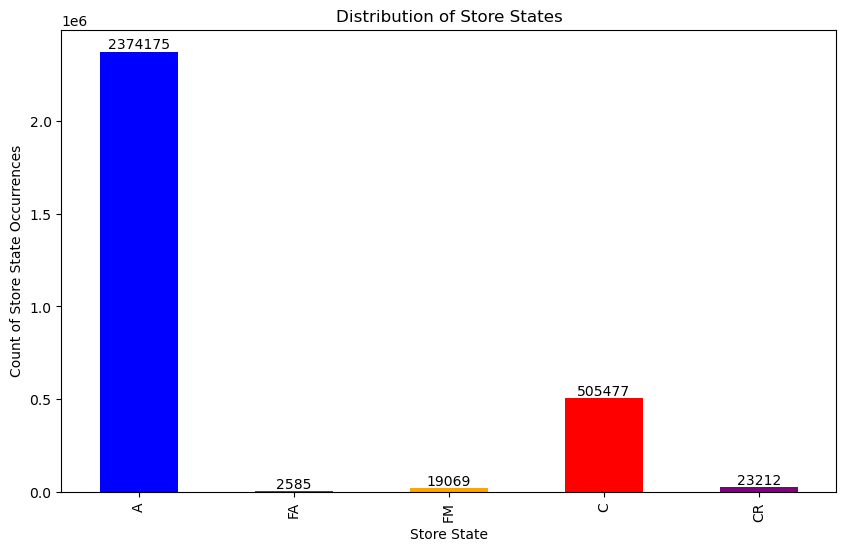

In [362]:
calendar_df_tmp_extended = pd.DataFrame(calendar_df['DATE'].unique(), columns=['DATE'])

calendar_df_tmp_extended['A'] = 0
calendar_df_tmp_extended['FA'] = 0
calendar_df_tmp_extended['FM'] = 0
calendar_df_tmp_extended['C'] = 0
calendar_df_tmp_extended['CR'] = 0

a_stores_count = calendar_df[calendar_df['STATE'] == 'A'].groupby('DATE').size()
fa_stores_count = calendar_df[calendar_df['STATE'] == 'FA'].groupby('DATE').size()
fm_stores_count = calendar_df[calendar_df['STATE'] == 'FM'].groupby('DATE').size()
c_stores_count = calendar_df[calendar_df['STATE'] == 'C'].groupby('DATE').size()
cr_stores_count = calendar_df[calendar_df['STATE'] == 'CR'].groupby('DATE').size()

calendar_df_tmp_extended.set_index('DATE', inplace=True)

calendar_df_tmp_extended['A'] = a_stores_count
calendar_df_tmp_extended['FA'] = fa_stores_count
calendar_df_tmp_extended['FM'] = fm_stores_count
calendar_df_tmp_extended['C'] = c_stores_count
calendar_df_tmp_extended['CR'] = cr_stores_count

calendar_df_tmp_extended.reset_index(inplace=True)

# Fill missing values with 0 and ensure all columns are integers
calendar_df_tmp_extended.fillna(0, inplace=True)
calendar_df_tmp_extended[['A', 'FA', 'FM', 'C', 'CR']] = calendar_df_tmp_extended[['A', 'FA', 'FM', 'C', 'CR']].astype(int)



# Explore distribution of labels in calendar
plt.figure(figsize=(10, 6))
ax = state_counts.plot(kind='bar', color=['blue', 'green', 'orange', 'red', 'purple'])

# Add count labels on top of each bar
for i, count in enumerate(state_counts):
    ax.text(i, count + 100, str(int(count)), ha='center', va='bottom', fontsize=10)

# Add title and labels
plt.title('Distribution of Store States')
plt.xlabel('Store State')
plt.ylabel('Count of Store State Occurrences')

# Create a custom legend on the upper right side
#plt.legend(['C: Closed', 'A: Open', 'FA: Open on holiday', 'FM: Open on holiday until noon', 'CR: Closed for renovation'], 
#           loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12, frameon=True, shadow=True)

# Show the plot
plt.show()

In [365]:
merged_sales_ipc_df['DATE'] = pd.to_datetime(merged_sales_ipc_df['DATE'])
calendar_df_tmp_extended['DATE'] = pd.to_datetime(calendar_df_tmp_extended['DATE'])
merged_sales_ipc_calendar_df = pd.merge(merged_sales_ipc_df, calendar_df_tmp_extended, on='DATE', how='left')
merged_sales_ipc_calendar_df.head()

,DATE,SALES,CUMULATIVE_SALES_ALL,HOLIDAY,Year,Month,DayOfWeek,YearMonth,IPC_VALUE,A,FA,FM,C,CR
0,2015-01-01,1.103868e+03,1.103868e+03,False,2015,1,3,2015-01,-0.4,0,0,0,1521,0
1,2015-01-02,1.317074e+07,1.317184e+07,False,2015,1,4,2015-01,-0.4,1508,0,0,13,0
2,2015-01-03,1.616656e+07,2.933840e+07,False,2015,1,5,2015-01,-0.4,1521,0,0,0,0
3,2015-01-04,1.267257e+05,2.946512e+07,False,2015,1,6,2015-01,-0.4,0,10,0,1511,0
4,2015-01-05,1.791498e+07,4.738010e+07,False,2015,1,0,2015-01,-0.4,1520,0,0,1,0


The dataset `merged_sales_ipc_calendar_df` is well-suited to serve as input for our forecasting model. It integrates key features such as sales data, inflation (IPC) values, and store operational status (open/closed), providing a comprehensive set of variables that capture both economic and operational factors influencing sales.

In [367]:
# Save the merged_sales_ipc_calendar_df into a CSV file
merged_sales_ipc_calendar_df.to_csv('../data/Sales_ipc_calendar_dataset.csv', index=False)

# The file will be saved in the current working directory
print("CSV file saved successfully!")

CSV file saved successfully!
